In [1]:
import torch, math
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from nets import Qnetn, MLP_NN
from taskmeta import SINTASK, SINTASK2, SINTASK3, SIN_xlow, SIN_xhigh


device, dtype = 'cpu', torch.float32
def tensor(data, rgrad=False):
    return torch.tensor(data, device=device, dtype=dtype, requires_grad=rgrad)

GRS = 12
RNG = np.random.default_rng(GRS)
randseed = lambda : RNG.integers(1, 10_000)
xl, xh = SIN_xlow, SIN_xhigh

HH = [1, 25, 25, 25, 1]
lossF = lambda pp, yy: 0.5 * (pp-yy)**2
lossM = lambda pp, yy: torch.sum(0.5 * (pp - yy) ** 2) 

NN = lambda : MLP_NN(HH, device, dtype, actF=nn.ReLU, seed=randseed())
NP = lambda ext_params: MLP_NN(ext_params, device, dtype, actF=nn.ReLU, seed=randseed(), from_param=True)

# Meta Learning

In [2]:
taskerL = [
    SINTASK2((7, 3), seed=randseed()),
    SINTASK2((6, 2), seed=randseed()),
    SINTASK2((5, 1), seed=randseed()),
    SINTASK2((4, 0), seed=randseed()),
    SINTASK2((3, -1), seed=randseed()),
] 
tasker = taskerL[4]

# algorithm

In [3]:
inner_epochs =  200
inner_lr =      0.001
train_K =       4
P = print

In [4]:
# load theta
model = NN()
model.load_external('reptile_pie') #<---- comment this to not use meta pie
model.info(show_vals=True)

--------------------------
~ N_LAYERS:[4]
~ D_TYPE:[torch.float32]
~ DEV:[cpu]
--------------------------
--> Weights[0]:: Params[25] of Shape[torch.Size([25, 1])]
 ~--> [PARAMETER TENSOR]: tensor([[ 0.0099],
        [ 0.0434],
        [ 0.1610],
        [ 0.2345],
        [ 0.0178],
        [ 0.0938],
        [ 0.0936],
        [ 0.1359],
        [ 0.1680],
        [-0.0072],
        [ 0.2056],
        [ 0.0312],
        [ 0.1123],
        [ 0.0720],
        [ 0.1384],
        [ 0.2024],
        [ 0.2462],
        [ 0.1701],
        [ 0.0190],
        [ 0.0618],
        [-0.0532],
        [ 0.0220],
        [ 0.1187],
        [ 0.1102],
        [ 0.0225]], requires_grad=True)
--> Bias[0]:: Params[25] of Shape[torch.Size([25])]
 ~--> [PARAMETER TENSOR]: tensor([-0.0747, -0.0545, -0.0731, -0.1734,  0.0592, -0.1887, -0.1400, -0.2720,
        -0.2188, -0.1112, -0.0990, -0.0431, -0.0077, -0.0298,  0.0145, -0.1477,
        -0.1332, -0.1129, -0.0199, -0.1560,  0.2042,  0.0219, -0.0395, -0.08

1376

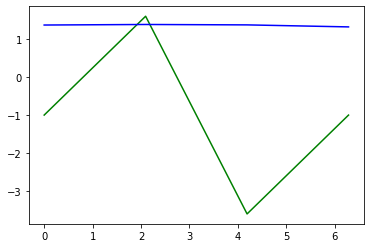

In [5]:
db =tasker.space(train_K)
bx = torch.tensor(np.expand_dims(db[ :, 0 ],axis=-1), dtype=torch.float32)
by = torch.tensor(np.expand_dims(db[ :, 1 ],axis=-1), dtype=torch.float32)
bp = []
with torch.no_grad():
    pred=model.forward(bx)
    plt.plot(db[:,0], db[:,1], color='green')
    plt.plot(db[:,0], pred, color='blue')


# training

	 Loss: 19.507436752319336
	 Loss: 10.059365272521973
	 Loss: 15.898962020874023
	 Loss: 27.344022750854492
	 Loss: 45.85482406616211
	 Loss: 25.77705955505371
	 Loss: 12.58438491821289
	 Loss: 16.324792861938477
	 Loss: 35.36853790283203
	 Loss: 3.3692755699157715
	 Loss: 14.450101852416992
	 Loss: 10.377007484436035
	 Loss: 21.56226348876953
	 Loss: 7.0359368324279785
	 Loss: 21.398462295532227
	 Loss: 13.903770446777344
	 Loss: 19.060962677001953
	 Loss: 21.187149047851562
	 Loss: 24.068710327148438
	 Loss: 15.394552230834961
	 Loss: 10.466573715209961
	 Loss: 6.4082255363464355
	 Loss: 16.76473045349121
	 Loss: 14.315515518188477
	 Loss: 15.808279037475586
	 Loss: 13.748208045959473
	 Loss: 23.48039436340332
	 Loss: 2.9568567276000977
	 Loss: 22.603214263916016
	 Loss: 6.655527114868164
	 Loss: 23.309377670288086
	 Loss: 24.241329193115234
	 Loss: 12.398568153381348
	 Loss: 17.874881744384766
	 Loss: 17.83870506286621
	 Loss: 18.40945053100586
	 Loss: 12.775181770324707
	 Loss: 16.

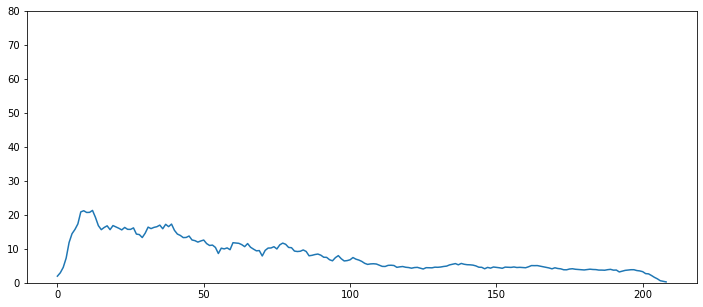

In [6]:


loss_hist=[]
for inner_epoch in range(inner_epochs):

    #P('# 5: sample train_K data points', train_K)
    train_db =tasker.sample(train_K)
    batch_x = torch.tensor(np.expand_dims(train_db[ :, 0 ],axis=-1), dtype=torch.float32)
    batch_y = torch.tensor(np.expand_dims(train_db[ :, 1 ],axis=-1), dtype=torch.float32)

    #P('# 6: evaluate grad_theta(loss)')
    model.zero_grad()
    pred = model.forward(batch_x)
    loss =  lossM(pred, batch_y) #torch.sum((pred - batch_y) ** 2) 
    
    loss_hist.append(loss.item())
    P('\t Loss:', loss_hist[-1])
    #loss.backward(create_graph=True)
    grads = torch.autograd.grad(loss, model.parameters, create_graph=False)

    #P('# 7: compute adapted paramters with grad descent')
    with torch.no_grad():
        for t_param, grad in zip(model.parameters, grads):
            t_param -= inner_lr * grad

npc = lambda n: np.ones(n) * (1/n)
plt.figure(figsize=(12,5))
plt.ylim(0,80)
plt.plot(np.convolve(loss_hist, npc(10)))
plt.show()

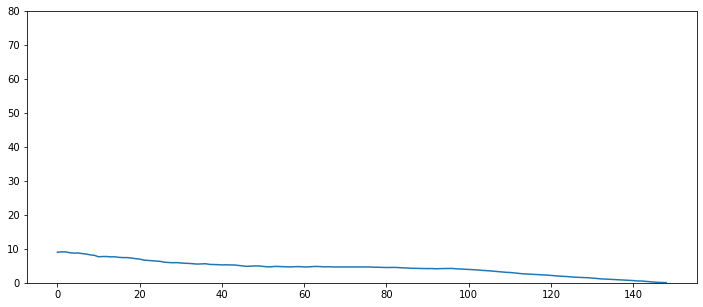

In [7]:
npc = lambda n: np.ones(n) * (1/n)
plt.figure(figsize=(12,5))
plt.ylim(0,80)
plt.plot(np.convolve(loss_hist, npc(50))[100:])
plt.show()

np.save('loss_h.npy', loss_hist)

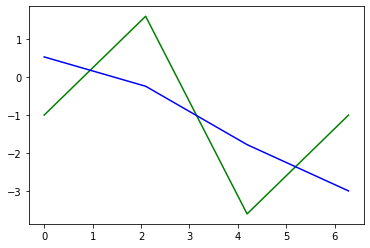

In [8]:
db =tasker.space(train_K)
bx = torch.tensor(np.expand_dims(db[ :, 0 ],axis=-1), dtype=torch.float32)
by = torch.tensor(np.expand_dims(db[ :, 1 ],axis=-1), dtype=torch.float32)
bp = []
with torch.no_grad():
    pred=model.forward(bx)
    plt.plot(db[:,0], db[:,1], color='green')
    plt.plot(db[:,0], pred, color='blue')
